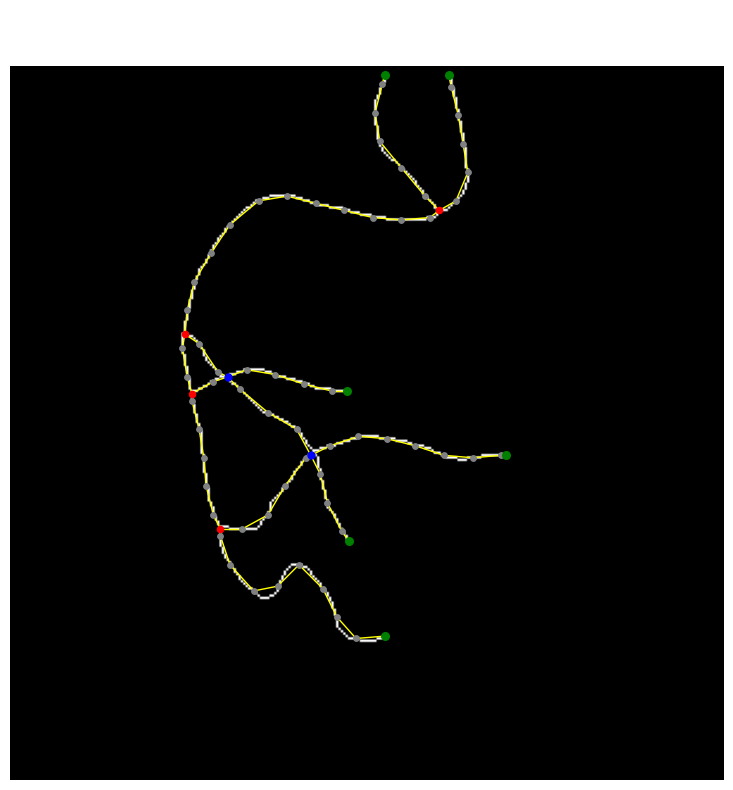

JSON guardado como 'graph_data.json'


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import json
from skimage.morphology import skeletonize
from skimage.io import imread

def load_and_preprocess_image(img_path):
    """
    Carga la imagen y la binariza sin invertir los valores.
    """
    image = imread(img_path, as_gray=True)
    binary_image = image > 0.5
    skeleton = skeletonize(binary_image)  # Aplicar esqueletización
    return skeleton.astype(np.uint8)

def find_pixel_neighbors(img, x, y):
    """
    Obtiene los vecinos de un píxel en la imagen binaria.
    """
    neighbors = [
        (x-1, y-1), (x-1, y), (x-1, y+1),
        (x,   y-1),           (x,   y+1),
        (x+1, y-1), (x+1, y), (x+1, y+1)
    ]
    return [(i, j) for i, j in neighbors if 0 <= i < img.shape[0] and 0 <= j < img.shape[1] and img[i, j] == 1]

def build_graph(skeleton):
    """
    Construye un grafo usando NetworkX donde los nodos son los píxeles del esqueleto.
    """
    G = nx.Graph()
    rows, cols = skeleton.shape
    for x in range(rows):
        for y in range(cols):
            if skeleton[x, y] == 1:
                neighbors = find_pixel_neighbors(skeleton, x, y)
                for neighbor in neighbors:
                    G.add_edge((x, y), neighbor)
    return G

def classify_nodes(G):
    """
    Clasifica los nodos en extremos, intermedios, bifurcaciones y trifurcaciones.
    """
    nodes = {"extremos": [], "intermedios": [], "bifurcaciones": [], "trifurcaciones": []}
    for node in G.nodes:
        degree = len(list(G.neighbors(node)))
        if degree == 1:
            nodes["extremos"].append(node)
        elif degree == 2:
            nodes["intermedios"].append(node)
        elif degree == 3:
            nodes["bifurcaciones"].append(node)
        else:
            nodes["trifurcaciones"].append(node)
    return nodes

def dfs_reduce_intermediates(G, nodes, step=3):
    """
    Reduce la cantidad de nodos intermedios usando un recorrido DFS y conservando 1 de cada 'step' nodos.
    """
    H = G.copy()
    visited = set()
    stack = list(nodes["extremos"])  # Usamos DFS con una pila
    count = 0
    while stack:
        node = stack.pop()
        if node in visited:
            continue
        visited.add(node)
        neighbors = list(H.neighbors(node))
        if len(neighbors) == 2 and count % step != 0:
            H.add_edge(neighbors[0], neighbors[1])
            H.remove_node(node)
        count += 1
        stack.extend(neighbors)
    return H

def merge_branching_chains(G, nodes):
    """
    Fusiona grupos consecutivos de bifurcaciones y trifurcaciones en un solo nodo representativo.
    """
    H = G.copy()
    all_branching_nodes = set(nodes["bifurcaciones"] + nodes["trifurcaciones"])
    visited = set()
    
    for node in all_branching_nodes:
        if node in visited or node not in H:
            continue
        
        # Encontrar la cadena de bifurcaciones conectadas
        chain = []
        stack = [node]
        while stack:
            current = stack.pop()
            if current in visited or current not in all_branching_nodes:
                continue
            visited.add(current)
            chain.append(current)
            for neighbor in H.neighbors(current):
                if neighbor in all_branching_nodes and neighbor not in visited:
                    stack.append(neighbor)
        
        # Determinar el nodo representativo (el más central en la lista)
        if len(chain) > 1:
            central_node = chain[len(chain) // 2]
            for merge_node in chain:
                if merge_node == central_node:
                    continue
                for neighbor in list(H.neighbors(merge_node)):
                    if neighbor != central_node:
                        H.add_edge(central_node, neighbor)
                H.remove_node(merge_node)
    
    return H

def visualize_graph(image, G, nodes):
    """
    Visualiza el grafo con colores según la clasificación de nodos.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap="gray")
    pos = {node: (node[1], node[0]) for node in G.nodes}
    
    # Dibujar aristas en amarillo
    nx.draw(G, pos, edge_color='yellow', node_size=10, with_labels=False)
    
    # Dibujar nodos en capas
    nx.draw_networkx_nodes(G, pos, nodelist=nodes["intermedios"], node_color='gray', node_size=15)
    nx.draw_networkx_nodes(G, pos, nodelist=nodes["bifurcaciones"], node_color='red', node_size=20)
    nx.draw_networkx_nodes(G, pos, nodelist=nodes["trifurcaciones"], node_color='blue', node_size=25)
    nx.draw_networkx_nodes(G, pos, nodelist=nodes["extremos"], node_color='green', node_size=30)
    
    plt.show()

def save_graph_json(G, nodes):
    """
    Guarda la estructura del grafo en un archivo JSON.
    """
    graph_data = {
        "nodos": list(G.nodes),
        "extremos": nodes["extremos"],
        "intermedios": nodes["intermedios"],
        "bifurcaciones": nodes["bifurcaciones"],
        "trifurcaciones": nodes["trifurcaciones"],
        "aristas": list(G.edges)
    }
    with open("graph_data.json", "w") as json_file:
        json.dump(graph_data, json_file, indent=4)
    print("JSON guardado como 'graph_data.json'")

def main(image_path):
    skeleton = load_and_preprocess_image(image_path)
    G = build_graph(skeleton)
    nodes = classify_nodes(G)
    G_reduced = dfs_reduce_intermediates(G, nodes, step=12)
    G_final = merge_branching_chains(G_reduced, nodes)
    
    # Reclasificar después de filtrado
    final_nodes = classify_nodes(G_final)
    
    # Visualizar con los colores adecuados
    visualize_graph(skeleton, G_final, final_nodes)
    
    # Guardar en JSON
    save_graph_json(G_final, final_nodes)

main("images/1_gt.pgm")
